<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D2_ComparingTasks/student/W1D2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D2_ComparingTasks/student/W1D2_Tutorial2.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 2: Contrastive learning for object recognition

**Week 1, Day 2: Comparing Tasks**

**By Neuromatch Academy**

__Content creators:__ Andrew F. Luo, Leila Wehbe

__Content reviewers:__ Samuele Bolotta, Yizhou Chen, RyeongKyung Yoon, Ruiyi Zhang, Lily Chamakura, Patrick Mineault

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Patrick Mineault


___


# Tutorial Objectives

*Estimated timing of tutorial: 40 minutes*

By the end of this tutorial, participants will be able to:

1. Understand why we want to do contrastive learning.
2. Understand the losses used in contrastive learning.
3. Train a network using contrastive learning on MNIST.

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "x4y79"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

---
# Setup



##  Install and import feedback gadget


In [ ]:
# @title Install and import feedback gadget

!pip install vibecheck numpy matplotlib torch torchvision tqdm ipysankeywidget ipywidgets seaborn --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()

feedback_prefix = "W1D2_T2"

In [1]:
# @title Import dependencies

import logging
import gc
import contextlib
import io

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

# Set up PyTorch backend configurations
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Numpy for numerical operations
import numpy as np

# Matplotlib & Seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for machine learning utilities
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perform high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Helper functions

# This is code from the pytorch metric learning package

def neg_inf(dtype):
    # Returns the smallest possible value for the given data type
    return torch.finfo(dtype).min

def small_val(dtype):
    # Returns the smallest positive value greater than zero for the given data type
    return torch.finfo(dtype).tiny

def to_dtype(x, tensor=None, dtype=None):
    # Converts tensor `x` to the specified `dtype`, or to the same dtype as `tensor`
    if not torch.is_autocast_enabled():
        dt = dtype if dtype is not None else tensor.dtype
        if x.dtype != dt:
            x = x.type(dt)
    return x

def get_matches_and_diffs(labels, ref_labels=None):
    # Returns tensors indicating matches and differences between pairs of labels
    if ref_labels is None:
        ref_labels = labels
    labels1 = labels.unsqueeze(1)  # Expand dimensions for comparison
    labels2 = ref_labels.unsqueeze(0)  # Expand dimensions for comparison
    matches = (labels1 == labels2).byte()  # Byte tensor of matches
    diffs = matches ^ 1  # Byte tensor of differences (inverse of matches)
    if ref_labels is labels:
        matches.fill_diagonal_(0)  # Remove self-matches
    return matches, diffs

def get_all_pairs_indices(labels, ref_labels=None):
    """
    Given a tensor of labels, this will return 4 tensors.
    The first 2 tensors are the indices which form all positive pairs
    The second 2 tensors are the indices which form all negative pairs
    """
    matches, diffs = get_matches_and_diffs(labels, ref_labels)
    a1_idx, p_idx = torch.where(matches)  # Indices for positive pairs
    a2_idx, n_idx = torch.where(diffs)  # Indices for negative pairs
    return a1_idx, p_idx, a2_idx, n_idx

def cos_sim(input_embeddings):
    # Computes cosine similarity matrix for input embeddings
    normed_embeddings = torch.nn.functional.normalize(input_embeddings, dim=-1)  # Normalize embeddings
    return normed_embeddings @ normed_embeddings.t()  # Cosine similarity matrix

# Section 1: Building the model

In [ ]:
# @title Video

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'oGs-90Nzzw8'), ('Bilibili', 'BV1pb421H7Tz')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_video")

## What is contrastive learning?

Contrastive learning is a form of self-supervised learning (SSL). Contrastive learning seeks to map inputs to a high-dimensional space, bringing similar examples closer together and pushing dissimilar examples farther apart.

It may not be immediately obvious why you want to engage in contrastive learning. Can't we just use a large 1000-class ImageNet-trained classifier to recognize every image? Contrastive learning proves useful when the number of classes is not known ahead of time. For example, if you wanted a network to recognize human faces, there are approximately 8 billion people on the planet, making it impractical to train a classification network with 8 billion output neurons. Instead, you can train a network to output a high-dimensional embedding for each image. With this approach, given a reference image of a person, the network can determine if a new photo is similar to or different from the reference image.

In this section, we will:

* Construct a model that maps images to a high-dimensional space.
* Visualize the geometric properties of the embedding prior to model training.

## Constructing the model

We'll now construct a fully connected artificial neural network for contrastive learning, built from residual blocks in the style of a ResNet. This will look much like a classification network, but without a classification head at the end. Instead, the network maps images to a high-dimensional space:

$$f(\mathbf{x}) = \mathbf{z}$$

where $f$ is the network, $\mathbf{x}$ is an input image and $\mathbf{z}$ is the embedding. $\mathbf{z}$ is real a vector with dimension `out_dim`, normalized to have a norm of 1. Later, we will train the network such that similar images have similar embeddings and dissimilar images have dissimilar embeddings.

### Building the model from residual blocks

We first define a residual block. The block contains a prenormalization step and a leaky ReLU activation function to help with vanishing gradients, in addition to linear layers. Residual networks tend to be easier to optimize than corresponding plain networks.

In [4]:
class ResidualBlock(nn.Module):
    # Follows "Identity Mappings in Deep Residual Networks", uses LayerNorm instead of BatchNorm, and LeakyReLU instead of ReLU
    def __init__(self, feat_in=128, feat_out=128, feat_hidden=256, use_norm=True):
        super().__init__()
        # Define the residual block with or without normalization
        if use_norm:
            self.block = nn.Sequential(
                nn.LayerNorm(feat_in),  # Layer normalization on input features
                nn.LeakyReLU(negative_slope=0.1),  # LeakyReLU activation
                nn.Linear(feat_in, feat_hidden),  # Linear layer transforming input to hidden features
                nn.LayerNorm(feat_hidden),  # Layer normalization on hidden features
                nn.LeakyReLU(negative_slope=0.1),  # LeakyReLU activation
                nn.Linear(feat_hidden, feat_out)  # Linear layer transforming hidden to output features
            )
        else:
            self.block = nn.Sequential(
                nn.LeakyReLU(negative_slope=0.1),  # LeakyReLU activation
                nn.Linear(feat_in, feat_hidden),  # Linear layer transforming input to hidden features
                nn.LeakyReLU(negative_slope=0.1),  # LeakyReLU activation
                nn.Linear(feat_hidden, feat_out)  # Linear layer transforming hidden to output features
            )

        # Define the bypass connection
        if feat_in != feat_out:
            self.bypass = nn.Linear(feat_in, feat_out)  # Linear layer to match dimensions if they differ
        else:
            self.bypass = nn.Identity()  # Identity layer if input and output dimensions are the same

    def forward(self, input_data):
        # Forward pass: apply the block and add the bypass connection
        return self.block(input_data) + self.bypass(input_data)

With this in hand, we'll build our network from a series of residual blocks. We use `nn.Sequential` to chain the blocks together.

In [5]:
class Model(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, num_blocks=4):
        super().__init__()
        # Initial linear projection from input dimension to hidden dimension
        self.in_proj = nn.Linear(in_dim, hidden_dim)
        # Sequence of residual blocks
        self.hidden = nn.Sequential(
            *[ResidualBlock(feat_in=hidden_dim, feat_out=hidden_dim, feat_hidden=hidden_dim) for i in range(num_blocks)]
        )
        # Output linear projection from hidden dimension to output dimension
        self.out = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        # Forward pass: input projection, passing through residual blocks, and final output projection
        in_proj_out = self.in_proj(x)
        hidden_out = self.hidden(in_proj_out)
        embedding = self.out(hidden_out)
        return F.normalize(embedding, p=2, dim=-1)

Notice that the output of the network is normalized using `F.normalize` so that each embedding has unit norm. Let's now look at the geometry of images processed by an untrained network. We first load data from MNIST.

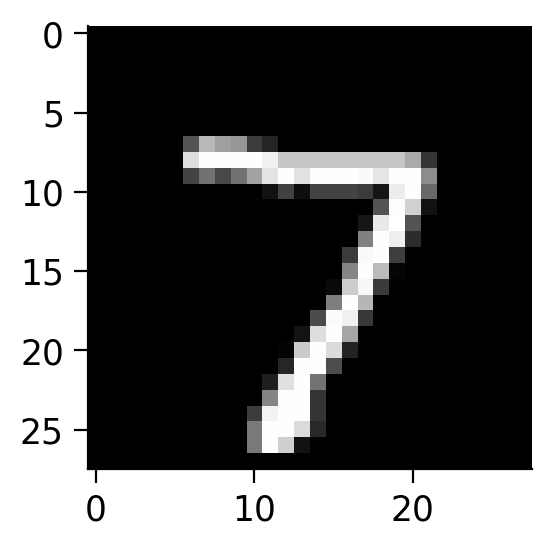

7


In [6]:
# Define the transformations for the MNIST dataset
mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert images to tensor
    torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Normalize the images with mean and standard deviation
])

with contextlib.redirect_stdout(io.StringIO()):
    # Load the MNIST test dataset with the defined transformations
    test_dset = torchvision.datasets.MNIST("./", train=False, transform=mnist_transforms, download=True)

# Calculate the height and width of the MNIST images (28x28)
height = int(784**0.5)
width = height

# Select the first image from the test dataset
idx = 0
data_point = test_dset[idx]

# Display the image using matplotlib
plt.figure(figsize=(3, 3))
plt.imshow(data_point[0][0].numpy(), cmap='gray')  # Display the image in grayscale
plt.show()

# Print the label of the selected image
print(data_point[1])

Now we will create the model using the definition we wrote previously and move it to the desired device. 

In [7]:
# Initialize the model with specified input, output, and hidden dimensions
mynet = Model(in_dim=784, out_dim=128, hidden_dim=256)

# Automatically select the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output the device that will be used
print(f"Using device: {device}")

# Move the model to the selected device
_ = mynet.to(device)

Using device: cpu


## The geometry of the untrained network

Let's visualize how close different examples are in the embedding space before training. We'll first gather the embeddings from multiple images by passing them through the network.

In [8]:
# First try with untrained network, find the cosine similarities within a class and across classes

# Create a DataLoader for the test dataset with a batch size of 50
test_loader = DataLoader(test_dset, batch_size=50, shuffle=False)  # enable persistent_workers=True if more than 1 worker to save CPU

# Set the model to evaluation mode
mynet.eval()

# Initialize lists to store test embeddings and labels
test_embeddings = []
test_labels = []

# Initialize a similarity matrix of size 10x10 for 10 classes
sim_matrix = np.zeros((10, 10))

# Disable gradient computation for inference
with torch.inference_mode():
    for data_batch in test_loader:
        test_img, test_label = data_batch  # Get images and labels from the batch
        batch_size = test_img.shape[0]  # Get the batch size
        flat = test_img.reshape(batch_size, -1).to(device, non_blocking=True)  # Flatten the images and move to device
        pred_embeddings = mynet(flat).cpu().numpy().tolist()  # Get embeddings from the model and move to CPU
        test_embeddings.extend(pred_embeddings)  # Store the embeddings
        test_labels.extend(test_label.numpy().tolist())  # Store the labels

# Convert embeddings and labels to numpy arrays
test_embeddings_untrained = np.array(test_embeddings)

# Convert test labels to numpy array
test_labels_untrained = np.array(test_labels)

### Code exercise 1: Visualizing the cosine similarity of embeddings within and across classes before training

In this exercise, we'll measure the cosine similarity between embeddings of images from the same class and across different classes. We'll visualize the cosine similarity matrix to see if the network has learned to distinguish between different classes. The cosine similarity between two embedding vectors $\mathbf{z}_1$ and $\mathbf{z}_2$ with norm 1 is defined as:

$$\text{sim}(\mathbf{z}_1, \mathbf{z}_2) = \mathbf{z}_1 \cdot \mathbf{z}_2$$

where $\cdot$ denotes the dot product. The cosine similarity ranges from -1 to 1, where:

* 1 indicates the vectors are identical
* 0 indicates that the vectors are orthogonal
* -1 indicates that the vectors are diametrically opposed. 

In [ ]:
# Dictionary to store normalized embeddings for each class
embeddings = {}
for i in range(10):
    embeddings[i] = test_embeddings_untrained[test_labels_untrained == i]

############################################################
# Fill in this code to compute cosine similarity matrix within the class.
raise NotImplementedError("Student exercise: calculate cosine similarity.")
############################################################

# Within class cosine similarity:
for i in range(10):
    sims = ...  # Compute cosine similarity matrix within the class
    np.fill_diagonal(sims, np.nan)  # Ignore diagonal values (self-similarity)
    cur_sim = np.nanmean(sims)  # Calculate the mean similarity excluding diagonal
    sim_matrix[i, i] = cur_sim  # Store the within-class similarity in the matrix

# Between class cosine similarity:
for i in range(10):
    for j in range(10):
        if i == j:
            continue  # Skip if same class (already computed)
        elif i > j:
            continue  # Skip if already computed (matrix symmetry)
        else:
            sims = embeddings[i] @ embeddings[j].T  # Compute cosine similarity between different classes
            cur_sim = np.mean(sims)  # Calculate the mean similarity
            sim_matrix[i, j] = cur_sim  # Store the similarity in the matrix
            sim_matrix[j, i] = cur_sim  # Ensure symmetry in the matrix

plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, vmin=0.0, vmax=1.0, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Untrained Network Cosine Similarity Matrix")
plt.show()

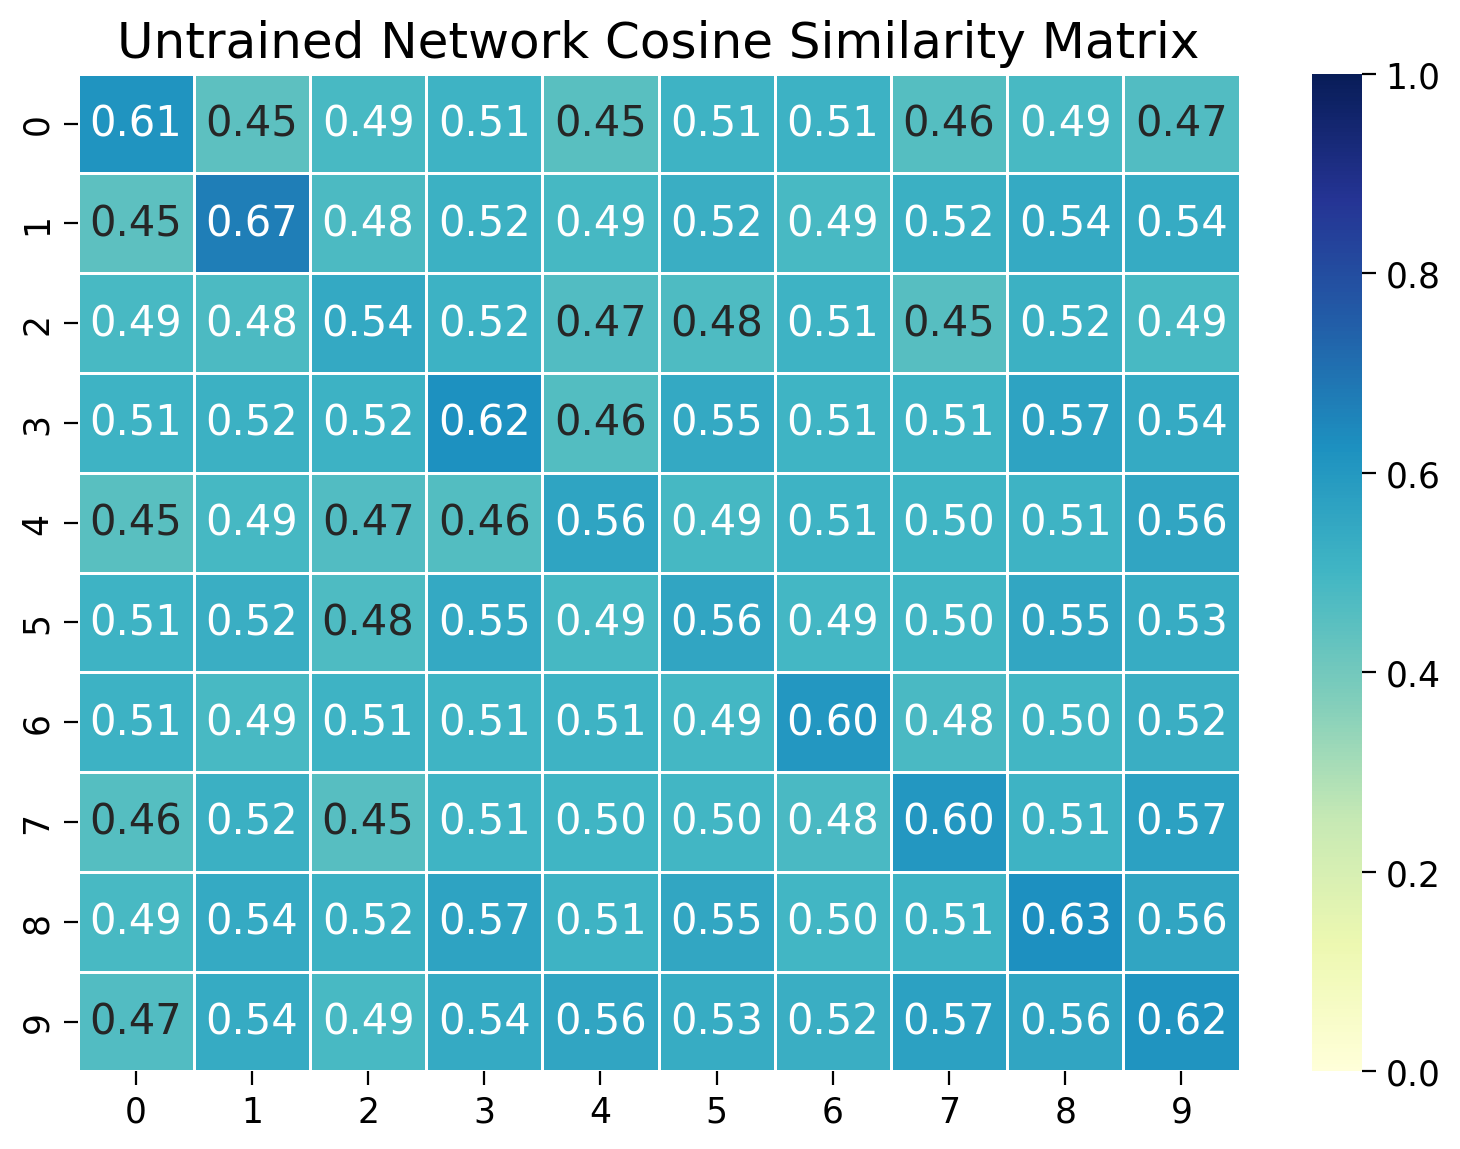

In [9]:
# to_remove solution

# Dictionary to store normalized embeddings for each class
embeddings = {}
for i in range(10):
    embeddings[i] = test_embeddings_untrained[test_labels_untrained == i]

# Within class cosine similarity:
for i in range(10):
    sims = embeddings[i] @ embeddings[i].T  # Compute cosine similarity matrix within the class
    np.fill_diagonal(sims, np.nan)  # Ignore diagonal values (self-similarity)
    cur_sim = np.nanmean(sims)  # Calculate the mean similarity excluding diagonal
    sim_matrix[i, i] = cur_sim  # Store the within-class similarity in the matrix

# Between class cosine similarity:
for i in range(10):
    for j in range(10):
        if i == j:
            continue  # Skip if same class (already computed)
        elif i > j:
            continue  # Skip if already computed (matrix symmetry)
        else:
            sims = embeddings[i] @ embeddings[j].T  # Compute cosine similarity between different classes
            cur_sim = np.mean(sims)  # Calculate the mean similarity
            sim_matrix[i, j] = cur_sim  # Store the similarity in the matrix
            sim_matrix[j, i] = cur_sim  # Ensure symmetry in the matrix

plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, vmin=0.0, vmax=1.0, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Untrained Network Cosine Similarity Matrix")
plt.show()

In [17]:
test_embeddings_untrained[0]

array([ 0.04287171, -0.05826555,  0.06932789, -0.03550113, -0.04797931,
        0.0701883 , -0.00855074, -0.08905289, -0.03835814, -0.0611041 ,
        0.11720877, -0.04872797,  0.02856323,  0.0656321 ,  0.04796745,
       -0.11665686,  0.09843384,  0.14736591, -0.02156601, -0.09843634,
        0.04230912, -0.00870593,  0.2877515 , -0.06523596,  0.00796823,
        0.07312007, -0.09392508,  0.04098218,  0.10692832,  0.02346992,
       -0.15947048,  0.09153154,  0.01046536, -0.06100506,  0.03139724,
        0.12266943, -0.10461517,  0.03645675, -0.07831571,  0.02622905,
       -0.02734803,  0.03109509, -0.00257721, -0.13118665, -0.08006996,
        0.06824253, -0.0712007 ,  0.02073681, -0.05412801, -0.02654658,
        0.03953722, -0.02428674,  0.04948665, -0.11219523, -0.03744444,
        0.09755569,  0.08478612,  0.01716746,  0.00747095,  0.12247735,
        0.24422061, -0.01728933,  0.1153579 , -0.11250784,  0.11553388,
        0.0042746 ,  0.02522134, -0.10646803,  0.1190397 ,  0.03

In [19]:
test_embeddings_untrained[2]

array([-0.01630733, -0.08280494,  0.07889801,  0.02511626, -0.20124531,
        0.11188854,  0.06003582, -0.04109006, -0.02005643,  0.01402585,
        0.09418241, -0.09753681,  0.05739639,  0.07147382,  0.07319384,
       -0.08324574,  0.00156494,  0.08202359, -0.03289558, -0.02452958,
        0.13106896, -0.01931463,  0.10479349,  0.07888805,  0.0148888 ,
        0.00259067, -0.08317477, -0.01799166,  0.00046983, -0.05788125,
       -0.02446666,  0.02667882, -0.01356553, -0.10828295, -0.05585857,
        0.00779862, -0.09181423,  0.15142585, -0.00830757,  0.04833959,
       -0.12800549,  0.08863446, -0.02376061, -0.03781029, -0.03446249,
        0.04666476, -0.06633209, -0.03467186, -0.07570077,  0.03094575,
        0.08639972,  0.0349064 ,  0.03063785, -0.17434405,  0.08871571,
        0.03186274,  0.06436992, -0.02131906, -0.05703582,  0.14953804,
        0.11117696,  0.08056419,  0.09550061, -0.01538386,  0.09580229,
       -0.04101671, -0.0239546 , -0.03734923,  0.07253969,  0.02

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Code_Exercise_1")

### Reflection

What do you observe in the cosine similarity matrix? Are the embeddings from the same digit class more similar than embeddings of different classes?

In [ ]:
# to_remove explanation
"""
Since our network is untrained, there isn't much difference in the cosine similarities
within and across image classes. This lack of clear structure in the similarity matrix
is expected at this stage because the network has not yet learned to distinguish between
different classes.

Ideally, we should observe a very high cosine similarity for images within the same
class (along the diagonal) and very low cosine similarity for images from different
classes (off-diagonal).
"""

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_1")

# Section 2: Training the model and visualizing feature similarity 

Let's train the network to pull elements of the same class together and push elements of different classes apart. We'll use a contrastive loss function to do this. 

## The contrastive loss function

Our goal is to train the model to put similar examples close together and dissimilar examples far away from each other. We can achieve this by minimizing a contrastive loss function.

![Triplet loss minimization](https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D2_ComparingTasks/static/triplet_loss_minimization.png)

Let's first consider a single anchor image whose embedding is $\mathbf{z}_a$. We want to compare this against a set of embeddings for different images $\mathbf{z}_k$, where $k \in [0 \ldots K]$. We have a single positive image $\mathbf{z}_0$ of the same class as the anchor image, while the negative images $\mathbf{z}_{[1 \ldots K]}$ are images of other classes. We want to minimize the distance between the anchor image and the positive image while maximizing the distance between the anchor image and the negative images.

A classic way to do this is via the InfoNCE loss function, which is widely used in contrastive learning, for example in OpenAI's CLIP. This loss is defined as:

$$ \mathcal{L}_a = -\log \left( \frac{\exp(\mathbf{z}_a \cdot \mathbf{z}_{0} / \tau)}{\sum_{k=0}^{K} \exp(\mathbf{z}_a \cdot \mathbf{z}_k / \tau)} \right) $$

Here $\tau$ is a temperature parameter that controls the sharpness of the distribution. You can think of it as a cross-entropy loss with a single pseudo-class corresponding to similar labels and the negative pairs corresponding to different labels. 

### Decoupled constrastive learning

InfoNCE typically requires substantial batch sizes—commonly 128 or larger—to perform optimally. The need for large batch sizes stems from the necessity for diverse negative samples in the batch to effectively learn the contrasts. However, large batch sizes can be impractical in resource-constrained settings or when data availability is limited.

To address this, we will implement a modified version of InfoNCE as described in the ["Decoupled Contrastive Learning"](https://link.springer.com/chapter/10.1007/978-3-031-19809-0_38) paper. This variant adapts the loss to be more suitable for smaller batch sizes by modifying the denominator of the InfoNCE formula. Specifically, it removes the positive example from the denominator, which reduces the computational demand and stabilizes training when fewer examples are available. This adjustment not only makes the loss function more flexible, but also maintains robustness in learning discriminative features even with smaller batch sizes.

$$ \mathcal{L}_a = -\log \left( \frac{\exp(\mathbf{z}_a \cdot \mathbf{z}_{0} / \tau)}{\sum_{k=1}^{K} \exp(\mathbf{z}_a \cdot \mathbf{z}_k / \tau)} \right) $$

### Batching and numerical stability

In practice, we will sample an entire batch of images at a time. We will then compute the average decoupled contrastive loss for every positive pair of images that have the same label. Thus:

$$ \mathcal{L}_{\text{batch}} = \frac{1}{N_{\text{positive pairs}}} \sum_{\text{positive pairs (i, j)}} -\log \left( \frac{\exp(\mathbf{z}_i \cdot \mathbf{z}_{j} / \tau)}{\sum_{k \in \text{Negative(i)}} \exp(\mathbf{z}_i \cdot \mathbf{z}_k / \tau)} \right) $$

Here $i$ corresponds to the index of a single image, and $\text{Negative(i)}$ is the set of indices of all the negative images corresponding to anchor image $i$ (all the images with labels that differ from the anchor image). 

To prevent the exponential from overflowing, we'll subtract the maximum value from the dot products before exponentiating. This is a common trick to improve numerical stability.

## Code exercise 2: The decoupled contrastive learning loss function

Let's first complete the implementation of the Decoupled Contrastive Learning (DCL) loss function to better grasp how it separates positive and negative pairs. The total training time might take around 5 minutes.

In [ ]:
def dcl_loss(pos_pairs, neg_pairs, indices_tuple, temperature=0.07):
    ############################################################
    # First question: Think about how you can ensure that non-matching pairs do
    # not contribute to the denominator in the loss calculation. You need to set their
    # values to a large negative number to effectively exclude them from the
    # exponential computation. Second question: Look at the numerator in the formula!
    raise NotImplementedError("Student exercise: complete DCL loss function.")
    ############################################################
    """
    Computes the Decoupled Contrastive Learning loss.

    Returns:
        torch.Tensor: The computed loss value.
    """
    a1, _, a2, _ = indices_tuple  # Unpack indices

    if len(a1) == 0 or len(a2) == 0:
        return 0

    dtype = neg_pairs.dtype
    pos_pairs = pos_pairs.unsqueeze(1) / temperature  # Scale positive pairs by temperature
    neg_pairs = neg_pairs / temperature  # Scale negative pairs by temperature
    n_per_p = to_dtype(a2.unsqueeze(0) == a1.unsqueeze(1), dtype=dtype)  # Indicator matrix for matching pairs
    neg_pairs = neg_pairs * n_per_p  # Zero out non-matching pairs
    neg_pairs[n_per_p == 0] = ...  # Replace non-matching pairs with negative infinity

    # Compute the maximum value for numerical stability
    max_val = torch.max(
        pos_pairs, torch.max(neg_pairs, dim=1, keepdim=True)[0]
    ).detach()
    # Compute numerator and denominator for the loss
    numerator = ...
    denominator = torch.sum(torch.exp(neg_pairs - max_val), dim=1)
    log_exp = torch.log((numerator / denominator) + small_val(dtype))
    return -log_exp  # Return the negative log of the exponential

def pair_based_loss(similarities, indices_tuple, lossfunc):
    """
    Computes pair-based loss using the provided loss function.

    Args:
        similarities : torch.Tensor
            A tensor of pairwise similarities. For n_examples, the shape should be
            (n_examples, n_examples).
        indices_tuple : tuple
            A tuple of indices for positive and negative pairs. The tuple should
            contain 4 tensors: a1, p, a2, n. The tensors a1 and p contain indices
            for positive pairs, while a2 and n contain indices for negative pairs.
            a1 and p should have the same length, and a2 and n should have the same
            length. a1[i] and p[i] should form a positive pair, such that they have the
            same label. Similarly, a2[i] and n[i] should form a negative pair, such that
            they have different labels.
        lossfunc : function
            The loss function to be applied for computing the loss.
    """
    # Computes pair-based loss using the provided loss function
    a1, p, a2, n = indices_tuple  # Unpack indices
    pos_pair, neg_pair = [], []
    if len(a1) > 0:
        pos_pair = similarities[a1, p]  # Extract positive pairs
    if len(a2) > 0:
        neg_pair = similarities[a2, n]  # Extract negative pairs
    return lossfunc(pos_pair, neg_pair, indices_tuple)  # Apply loss function

# Number of epochs for training
epochs = 10

# Automatically select the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output the device that will be used
print(f"Using device: {device}")

# Load the MNIST training dataset with the defined transformations
train_dset = torchvision.datasets.MNIST("./", train=True, transform=mnist_transforms)
train_loader = DataLoader(train_dset, batch_size=50, shuffle=True)  # Enable persistent_workers=True if more than 1 worker to save CPU

# Cleanup: delete the network and free up memory if this block is re-run
try:
    del mynet
    gc.collect()
    torch.cuda.empty_cache()
except:
    pass

# Initialize the model with specified input, output, and hidden dimensions
mynet = Model(in_dim=784, out_dim=128, hidden_dim=256)
_ = mynet.to(device)  # Move the model to the selected device

# Enable training mode, which may affect dropout and other layers
mynet.train(mode=True)
print("Is the network in training mode?", mynet.training)

# Initial learning rate and decay factor for the optimizer
init_lr = 3e-4
lr_decay_factor = 0.5

# Initialize the optimizer with model parameters and learning rate
optimizer = torch.optim.AdamW(mynet.parameters(), lr=init_lr, weight_decay=1e-2)

# Tracker to keep track of loss values during training
loss_tracker = []

# Training loop over the specified number of epochs
for epoch_id in range(1, epochs+1):
    loss_epoch_tracker = 0
    batch_counter = 0

    # Adjust learning rate for the current epoch
    new_lrate = init_lr * (lr_decay_factor ** (epoch_id / epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lrate

    batches_in_epoch = len(train_loader)
    for data_batch in train_loader:
        optimizer.zero_grad()  # Zero out gradients

        # Get images and labels from the batch
        train_img, train_label = data_batch
        batch_size = train_img.shape[0]

        # Flatten images and move data to the selected device
        flat = train_img.reshape(batch_size, -1).to(device, non_blocking=True)
        train_label = train_label.to(device, non_blocking=True)

        # Forward pass through the network
        predicted_results = mynet(flat)

        # Compute cosine similarity matrix for the batch
        similarities = cos_sim(predicted_results)

        # Get pairs of indices for positive and negative pairs
        label_pos_neg = get_all_pairs_indices(train_label)

        # Compute the loss using the decoupled contrastive learning loss function
        final_loss = torch.mean(pair_based_loss(similarities, label_pos_neg, dcl_loss))

        # Compute gradients from the loss
        final_loss.backward()

        # Update the model parameters using the optimizer
        optimizer.step()

        # Convert the loss to a single CPU scalar
        loss_cpu_number = final_loss.item()

        # Keep track of the losses for visualization
        loss_epoch_tracker += loss_cpu_number
        batch_counter += 1

        # Print the current epoch, batch number, and loss every 500 batches
        if batch_counter % 500 == 0:
            print("Epoch {}, Batch {}/{}, loss: {}".format(epoch_id, batch_counter, batches_in_epoch, loss_cpu_number))

    # Print the average loss for the epoch
    print("Epoch average loss {}".format(loss_epoch_tracker / batch_counter))

In [ ]:
# to_remove solution

def dcl_loss(pos_pairs, neg_pairs, indices_tuple, temperature=0.07):
    """
    Computes the Decoupled Contrastive Learning loss.

    Returns:
        torch.Tensor: The computed loss value.
    """
    a1, _, a2, _ = indices_tuple  # Unpack indices

    if len(a1) == 0 or len(a2) == 0:
        return 0

    dtype = neg_pairs.dtype
    pos_pairs = pos_pairs.unsqueeze(1) / temperature  # Scale positive pairs by temperature
    neg_pairs = neg_pairs / temperature  # Scale negative pairs by temperature
    n_per_p = to_dtype(a2.unsqueeze(0) == a1.unsqueeze(1), dtype=dtype)  # Indicator matrix for matching pairs
    neg_pairs = neg_pairs * n_per_p  # Zero out non-matching pairs
    neg_pairs[n_per_p == 0] = neg_inf(dtype)  # Replace non-matching pairs with negative infinity

    # Compute the maximum value for numerical stability
    max_val = torch.max(
        pos_pairs, torch.max(neg_pairs, dim=1, keepdim=True)[0]
    ).detach()
    # Compute numerator and denominator for the loss
    numerator = torch.exp(pos_pairs - max_val).squeeze(1)
    denominator = torch.sum(torch.exp(neg_pairs - max_val), dim=1)
    log_exp = torch.log((numerator / denominator) + small_val(dtype))
    return -log_exp  # Return the negative log of the exponential

def pair_based_loss(similarities, indices_tuple, lossfunc):
    """
    Computes pair-based loss using the provided loss function.

    Args:
        similarities : torch.Tensor
            A tensor of pairwise similarities. For n_examples, the shape should be
            (n_examples, n_examples).
        indices_tuple : tuple
            A tuple of indices for positive and negative pairs. The tuple should
            contain 4 tensors: a1, p, a2, n. The tensors a1 and p contain indices
            for positive pairs, while a2 and n contain indices for negative pairs.
            a1 and p should have the same length, and a2 and n should have the same
            length. a1[i] and p[i] should form a positive pair, such that they have the
            same label. Similarly, a2[i] and n[i] should form a negative pair, such that
            they have different labels.
        lossfunc : function
            The loss function to be applied for computing the loss.
    """
    # Computes pair-based loss using the provided loss function
    a1, p, a2, n = indices_tuple  # Unpack indices
    pos_pair, neg_pair = [], []
    if len(a1) > 0:
        pos_pair = similarities[a1, p]  # Extract positive pairs
    if len(a2) > 0:
        neg_pair = similarities[a2, n]  # Extract negative pairs
    return lossfunc(pos_pair, neg_pair, indices_tuple)  # Apply loss function

# Number of epochs for training
epochs = 10

# Automatically select the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output the device that will be used
print(f"Using device: {device}")

# Load the MNIST training dataset with the defined transformations
train_dset = torchvision.datasets.MNIST("./", train=True, transform=mnist_transforms)
train_loader = DataLoader(train_dset, batch_size=50, shuffle=True)  # Enable persistent_workers=True if more than 1 worker to save CPU

# Cleanup: delete the network and free up memory if this block is re-run
try:
    del mynet
    gc.collect()
    torch.cuda.empty_cache()
except:
    pass

# Initialize the model with specified input, output, and hidden dimensions
mynet = Model(in_dim=784, out_dim=128, hidden_dim=256)
_ = mynet.to(device)  # Move the model to the selected device

# Enable training mode, which may affect dropout and other layers
mynet.train(mode=True)
print("Is the network in training mode?", mynet.training)

# Initial learning rate and decay factor for the optimizer
init_lr = 3e-4
lr_decay_factor = 0.5

# Initialize the optimizer with model parameters and learning rate
optimizer = torch.optim.AdamW(mynet.parameters(), lr=init_lr, weight_decay=1e-2)

# Tracker to keep track of loss values during training
loss_tracker = []

# Training loop over the specified number of epochs
for epoch_id in range(1, epochs+1):
    loss_epoch_tracker = 0
    batch_counter = 0

    # Adjust learning rate for the current epoch
    new_lrate = init_lr * (lr_decay_factor ** (epoch_id / epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lrate

    batches_in_epoch = len(train_loader)
    for data_batch in train_loader:
        optimizer.zero_grad()  # Zero out gradients

        # Get images and labels from the batch
        train_img, train_label = data_batch
        batch_size = train_img.shape[0]

        # Flatten images and move data to the selected device
        flat = train_img.reshape(batch_size, -1).to(device, non_blocking=True)
        train_label = train_label.to(device, non_blocking=True)

        # Forward pass through the network
        predicted_results = mynet(flat)

        # Compute cosine similarity matrix for the batch
        similarities = cos_sim(predicted_results)

        # Get pairs of indices for positive and negative pairs
        label_pos_neg = get_all_pairs_indices(train_label)

        # Compute the loss using the decoupled contrastive learning loss function
        final_loss = torch.mean(pair_based_loss(similarities, label_pos_neg, dcl_loss))

        # Compute gradients from the loss
        final_loss.backward()

        # Update the model parameters using the optimizer
        optimizer.step()

        # Convert the loss to a single CPU scalar
        loss_cpu_number = final_loss.item()

        # Keep track of the losses for visualization
        loss_epoch_tracker += loss_cpu_number
        batch_counter += 1

        # Print the current epoch, batch number, and loss every 500 batches
        if batch_counter % 500 == 0:
            print("Epoch {}, Batch {}/{}, loss: {}".format(epoch_id, batch_counter, batches_in_epoch, loss_cpu_number))

    # Print the average loss for the epoch
    print("Epoch average loss {}".format(loss_epoch_tracker / batch_counter))

Great, we have a trained network! Let's collect the embeddings from the model.

In [ ]:
def get_embeddings_labels(loader, model):
    """
    Function to extract embeddings and labels from a given data loader and model
    Args:
        loader (DataLoader): DataLoader object containing the dataset
        model (nn.Module): Model object to extract embeddings

    Returns:
        embeddings (np.array): NumPy array of embeddings
        labels (np.array): NumPy array of labels
    """
    # Initialize lists to store embeddings and labels
    embeddings = []
    labels = []

    # Set the model to evaluation
    model.eval()

    # Disable gradient computation for inference
    with torch.inference_mode():
        for data_batch in loader:
            # Get images and labels from the batch
            img, label = data_batch
            batch_size = img.shape[0]

            # Flatten images and move data to the selected device
            flat = img.reshape(batch_size, -1).to(device, non_blocking=True)

            # Forward pass through the network
            pred_results = model(flat).cpu().numpy().tolist()

            # Store the embeddings and labels
            embeddings.extend(pred_results)
            labels.extend(label.numpy().tolist())
    return np.array(embeddings), np.array(labels)

# DataLoader for the test dataset with a batch size of 50
test_loader = DataLoader(test_dset, batch_size=50, shuffle=False)  # Enable persistent_workers=True if more than 1 worker to save CPU
test_embeddings, test_labels = get_embeddings_labels(test_loader, mynet)

train_loader = DataLoader(train_dset, batch_size=50, shuffle=False)  # Enable persistent_workers=True if more than 1 worker to save CPU
train_embeddings, train_labels = get_embeddings_labels(train_loader, mynet)

# Indicate that feature extraction is complete
print("Feature extraction done!")

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Code_Exercise_2")

## Visualizing the cosine similarity after training

Let's start by double-checking that the network has learned to distinguish between different classes. We'll measure the cosine similarity between embeddings of images within and across classes. We'll visualize the cosine similarity matrix to see if the network has learned to distinguish between different classes.

In [ ]:
# Create DataLoader for the test dataset with a batch size of 50
test_loader = DataLoader(test_dset, batch_size=50, shuffle=False)  # Enable persistent_workers=True if more than 1 worker to save CPU

# Set the model to evaluation mode
mynet.eval()

# Initialize lists to store test embeddings and labels
test_embeddings = []
test_labels = []

# Initialize a similarity matrix of size 10x10 for 10 classes
sim_matrix = np.zeros((10, 10))

# Disable gradient computation for inference
with torch.inference_mode():
    for data_batch in test_loader:
        # Get images and labels from the batch
        test_img, test_label = data_batch
        batch_size = test_img.shape[0]  # Get the batch size

        # Flatten images and move data to the selected device
        flat = test_img.reshape(batch_size, -1).to(device, non_blocking=True)

        # Get embeddings from the model and move to CPU
        pred_embeddings = mynet(flat).cpu().numpy().tolist()

        # Store the embeddings and labels
        test_embeddings.extend(pred_embeddings)
        test_labels.extend(test_label.numpy().tolist())

# Convert embeddings and labels to numpy arrays for further processing
test_embeddings = np.array(test_embeddings)

# Normalize the embeddings to unit length by dividing each embedding by its L2 norm
test_embeddings_normed = test_embeddings / np.linalg.norm(test_embeddings, axis=1, keepdims=True)

# Convert test labels to a numpy array
test_labels = np.array(test_labels)

# Dictionary to store normalized embeddings for each class
embeddings = {}
for i in range(10):
    embeddings[i] = test_embeddings_normed[test_labels == i]

# Calculate within-class cosine similarity
for i in range(10):
    # Compute cosine similarity matrix within the class
    sims = embeddings[i] @ embeddings[i].T

    # Ignore diagonal values (self-similarity)
    np.fill_diagonal(sims, np.nan)

    # Calculate the mean similarity excluding diagonal
    cur_sim = np.nanmean(sims)

    # Store the within-class similarity in the matrix
    sim_matrix[i, i] = cur_sim

# Calculate between-class cosine similarity
for i in range(10):
    for j in range(10):
        if i == j:
            pass  # Skip if same class (already computed)
        elif i > j:
            pass  # Skip if already computed (matrix symmetry)
        else:
            # Compute cosine similarity between different classes
            sims = embeddings[i] @ embeddings[j].T

            # Calculate the mean similarity
            cur_sim = np.mean(sims)

            # Store the similarity in the matrix
            sim_matrix[i, j] = cur_sim
            sim_matrix[j, i] = cur_sim  # Ensure symmetry in the matrix


# Plot the similarity matrix using matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, vmin=0.0, vmax=1.0, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Trained Network Cosine Similarity Matrix")
plt.show()

We see that the network has rapidly learned to distinguish between different classes and cluster similar examples together, despite not being trained to classify images directly.

## Visualizing the geometry of the embeddings before and after training

Let's use t-SNE to visualize the geometry of the embeddings before and after training. 

In [ ]:
# Convert list of embeddings to a numpy array
test_embeddings_untrained = np.array(test_embeddings_untrained)

# Initialize t-SNE with 2 components for dimensionality reduction
tsne = TSNE(n_components=2)

# Notify that the t-SNE transformation may take some time
print("t-SNE transformation in progress... This may take a minute")

# Fit t-SNE on the normalized embeddings and transform them to 2D
tsne_embeddings_untrained = tsne.fit_transform(test_embeddings_untrained)

# Optional: Print the shape of the resulting t-SNE embeddings to verify
print("t-SNE embeddings shape:", test_embeddings_untrained.shape)

Similarly, for the trained network.

In [ ]:
# Convert list of embeddings to a numpy array
test_embeddings = np.array(test_embeddings)

# Initialize t-SNE with 2 components for dimensionality reduction
tsne = TSNE(n_components=2)

# Notify that the t-SNE transformation may take some time
print("t-SNE transformation in progress... This may take a minute")

# Fit t-SNE on the normalized embeddings and transform them to 2D
tsne_embeddings = tsne.fit_transform(test_embeddings)

# Optional: Print the shape of the resulting t-SNE embeddings to verify
print("t-SNE embeddings shape:", tsne_embeddings.shape)

Now plot the distribution of features before and after training.

In [ ]:
# Use t-SNE embeddings for visualization
plt.figure(figsize=(8, 4.5))
plt.subplot(121)
for num in range(10):
    plt.scatter(tsne_embeddings_untrained[test_labels_untrained==num, 0],
                tsne_embeddings_untrained[test_labels_untrained==num, 1])

plt.xlabel('t-sne dim 1')
plt.ylabel('t-sne dim 2')
plt.legend([f"Digit {i}" for i in range(10)])
plt.title('Before training')

plt.subplot(122)
for num in range(10):
    plt.scatter(tsne_embeddings[test_labels==num, 0], tsne_embeddings[test_labels==num, 1])

plt.xlabel('t-sne dim 1')
plt.ylabel('t-sne dim 2')
plt.legend([f"Digit {i}" for i in range(10)])
plt.title('After training')

Notice how training has pulled examples with similar labels together and pushed examples with different labels apart.

## Using the network to identify nearest neighbours from the train set

How can we actually use a contrastive learning network for a downstream task like classification? Some options include:

* **Fine-tuning**: Add a linear classification layer on top of the embedding. Fine-tune the model end-to-end for the downstream supervised task.
* **Nearest neighbour search**: Given a test anchor image, find the most similar image in the train set. Apply the same label to the test image as the most similar image in the train set.

Here, we will use a nearest neighbour search to find the most similar image in the train set.

In [ ]:
# Calculate the cosine similarity matrix between all the test images and the train images
sims_all = test_embeddings @ train_embeddings.T

# Index of the embedding to check for the most similar embedding
idx_to_check = 4

# Find the index of the most similar embedding (excluding itself)
best_idx = np.argmax(sims_all[idx_to_check])

# Plot the image corresponding to the index to check
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(test_dset[idx_to_check][0][0].cpu().numpy())
plt.title('Query image')

# Plot the image corresponding to the most similar embedding
plt.subplot(122)
plt.imshow(train_dset[best_idx][0][0].cpu().numpy())
plt.title('Nearest neighbor from train set')

In this one case, this nearest neighbor scheme works well. Let's measure the overall accuracy over the entire test set.

In [ ]:
best_idxs = np.argmax(sims_all, axis=1)
corresponding_labels = train_labels[best_idxs]
accuracy = np.mean(corresponding_labels == test_labels)
print(f"Mean accuracy: {accuracy}")

Not too bad for a simple nearest neighbour search! Contrastive learning has allowed us to learn a useful embedding space for recognizing digits. 

Keep in mind, however, that a nearest neighbour search can be impractical in real applications, as we'd need to keep the embeddings of all the train examples in memory. It's often more effective to fine-tune the network on the downstream task. This allows the network to learn task-specific features that may not be captured by the contrastive learning objective, and it can be more computationally efficient.

## How is contrastive learning used in practice?

Nearly all vision foundation models, such as DINO, DINOv2, CLIP, and their derivatives (including OpenCLIP and EVA-CLIP), are trained using contrastive losses. DINO and DINOv2 are trained solely on images, while CLIP is trained on a combination of images and text.

When only images are used, the contrastive learning loss is applied to augmentations of the same image. These augmentations can include crops, flips, and rotations, and this approach is referred to as a "pretext task." Typically, augmentations of the same image are treated as instances where the embeddings should be the same. For example, a network should recognize a photo of you and a photo of you flipped, with altered brightness, noise added, or converted to black and white, as representing the same person.

![A pretext task to classify puppies](https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D2_ComparingTasks/static/puppies.png)

*Photos by JimboMack66, CC-BY 2.0*

When images and text are used together, as in CLIP, the training data consists of images and their corresponding captions. For example, the caption "A photo of a dog" might be paired with a picture of a blue heeler puppy. These captions are typically scraped from online sources and collected into datasets like LAION-2B, COYO-700M, and CommonCrawl. Although these captions are often of varying quality, the sheer volume of data helps to mitigate this issue.

Multimodal contrastive learning typically employs a dual encoder system: one for text and one for images. The network is trained using a loss function that minimizes the distance between the correct text-image pairs while maximizing the distance between incorrect pairs. For example, the caption "A photo of a dog" should have embeddings close to the image of the blue heeler puppy and far from the image of a cat. To compute the "distance" of the embeddings, methods such as normalized dot-product (cosine similarity), angular distance (Universal Sentence Encoder), Euclidean distance, or squared Euclidean distance are often used.

## Discussion point

We have argued that judging similarity is an inherent capability of both human brains and artificial intelligence systems. We've covered many ways to implement contrastive learning in AI; can you speculate if and how contrastive learning might be implemented in the human brain? 

In [ ]:
# to_remove explanation
"""
Our brain's ability to perform contrastive learning is linked to the function of the ventral visual stream.
This area of the brain processes visual information and has been shown to develop hierarchical features that
capture the structure of visual input through self-supervised learning mechanisms. Evidence suggests that anterior
regions of the ventral visual stream, particularly the anterior occipito-temporal cortex (aOTC), encode substantial
information about object categories without requiring explicit category-level supervision (Konkle and Alvarez, 2022).
Instead, these representations emerge through domain-general learning from natural image structures, where the brain
differentiates between individual views and categories based on the inherent statistical properties of visual input
(Livingstone et al., 2019; Arcaro and Livingstone, 2021). This capability supports the notion that the brain's visual
system can form complex object representations and categorization using self-supervised learning frameworks similar to
those in artificial neural networks.
"""

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_2")

---
# Summary

In this tutorial, we've covered contrastive learning, a self-supervised technique that works well in situations where the number of classes is large or undefined. This method teaches a model to recognize similarity, not by traditional classification, but by learning to distinguish between 'similar' and 'dissimilar' directly through embeddings. We discussed the significance of generating embeddings that bring data points of the same class closer together while pushing different classes apart, which is particularly valuable in complex recognition tasks like identifying faces among billions of possibilities.

Through practical exercises with the MNIST dataset, we've seen how contrastive learning can be implemented. The session highlighted the intuitive appeal of contrastive learning: learning by comparison, which is a natural way for both humans and machines to understand the world.